### Попробуем здесь адаптировать новые формулы факторизации для модели Б-Ш, чтобы сравнить их впоследствии с имеющимися.

In [39]:
import numpy as np
from numpy import log, sqrt
from numpy import exp, linspace, fft, array, arange, pi
import matplotlib.pyplot as plt

Параметры контракта down-and-out put

In [40]:
# model parameters - we are going to evaluate a barrier put
T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

In [41]:
# Определим функцию выплат:
def G(y, barrier, strike):
    """payoff_function for a given option type (down-and-out put there)"""
    if (barrier <= y) and (y <= strike):
        return K_original - H_original*exp(y)
    else:
        return 0

In [42]:
# И функцию-индикатор:

def indicator(a, barrier):
    """the indicator influences the function argument, not value.
    So here it iterates through x-domain and cuts any
    values of function with an argument less than H"""
    indicated_array = []
    for index in range(len(y_space)):
        if y_space[index] > barrier:
            indicated_array.append(a[index])
        else:
            indicated_array.append(0)
    return indicated_array 

Характеристическая экспонента процесса Б-Ш
$$\psi(\xi) = \frac{{\color{green}{\sigma}}^2}{2} \xi^2 - i{\color{green}{\gamma}}\xi$$

In [43]:
sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

Подготавливаем дискретизацию, задаём шкалу по переменной, связанной с ценой, производим замены
$$ y = ln(S)$$
$$ K = ln(K), H = ln(H) $$

Укладываем $M$ точек между $L \cdot ln(1/2)$  и $ L \cdot ln(2) $

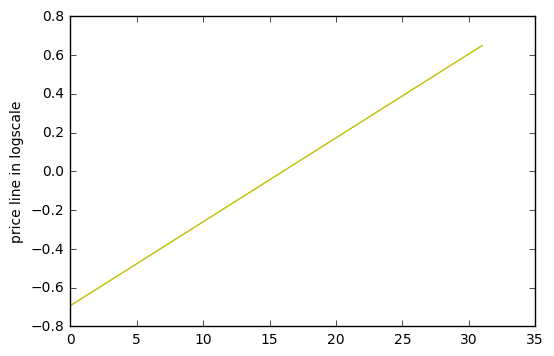

In [44]:
# constants in log scale for price, by Zanette
M = 2**5  # number of points in price grid
L = 1  # scaling coefficient
y_min = L * log(0.5)
y_max = L * log(2.0)
d = (y_max - y_min) / M  # discretization step
K = log(K_original/H_original)
H = log(H_original/H_original)
y_space = []  # prices array
for p_elem_index in range(M):
    y_space.append(y_min + p_elem_index * d)

plt.plot(y_space, color = 'y')
plt.ylabel('price line in logscale')
plt.show()

Теперь дискретизация по времени:

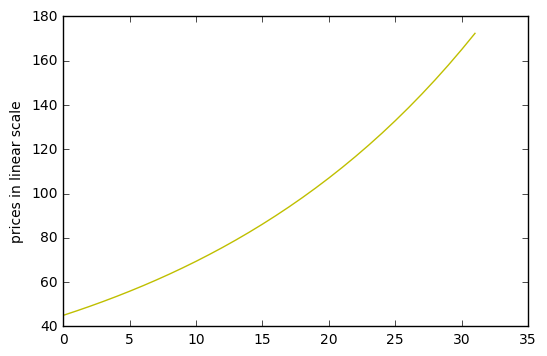

In [45]:
original_prices_array = H_original * exp(y_space)
# time discretization
N = 1  # number_of_time_steps
delta_t = T/N

plt.plot(original_prices_array, color = 'y')
plt.ylabel('prices in linear scale')
plt.show()

Величины, связанные с факторизацией. В этой модели всё просто - при постоянной вариации нет необходимости учитывать эффекты решётки волатильности.

Действие, которое мы хотим произвести на каждом шаге по времени, выглядит так:
$$f_n(y) = ({\color{green}{q\Delta t}}) ^{-1} \mathcal{E}_{\color{green}{q}}^- 1_{y>ln(H)} \mathcal{E}_{\color{green}{q}}^+ f_{n+1}(y)$$

Получить хотим $f_0(y)$, там для каждого y и ответ лежит

Зелёные - константы. Определим их.

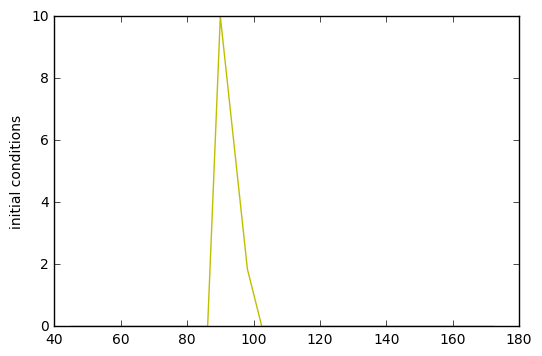

In [46]:
q = 1.0/delta_t + r
factor = (q*delta_t)**(-1)

# Зададим начальные уловия
f_N = array([G(y_element, H, K) for y_element in y_space]) # = g(x) i.e. payoff func

plt.plot(original_prices_array, f_N,  'y')
plt.ylabel('initial conditions')
plt.show()

В уравнении выше есть нигде пока не определённные функции (на самом деле, операторы)
$$ \mathcal{E}^\pm_q f(x) = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \hat{f}(\xi) d\xi $$


А в них - пока не определённые $\phi_q^\pm$

## Фи-минус

$\phi^-_q(\xi)$ будут иметь вид:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta =$$
$$= 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) =  $$
$$= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$
$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

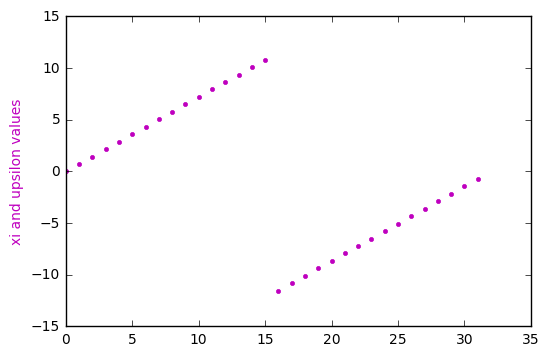

In [47]:
# преобразование Фурье должно допускать вычисление интеграла по \xi
# но поскольку мы имеем дело с ПДО, нужно ещё знать, с какими именно
xi_space = fft.fftfreq(M, d=d)
upsilon_space = fft.fftfreq(M, d=d)

omega_plus = 1

# Теперь надо поколдовать с функцией F(x). Кодировать её для каждого отдельного значения x можно, 
# но для этого придётся использовать медленные методы вычисления интегралов.
# Поэтому она должна принимать  массив длиной M и обрабатывать его.

plt.plot(xi_space, 'm.')
plt.ylabel('xi and upsilon values', color='m')
plt.show()

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2}, \upsilon \in \upsilon\_space$$

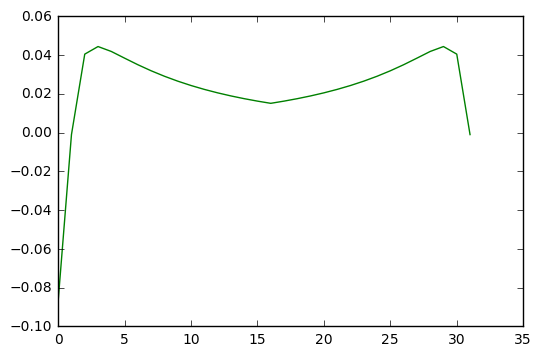

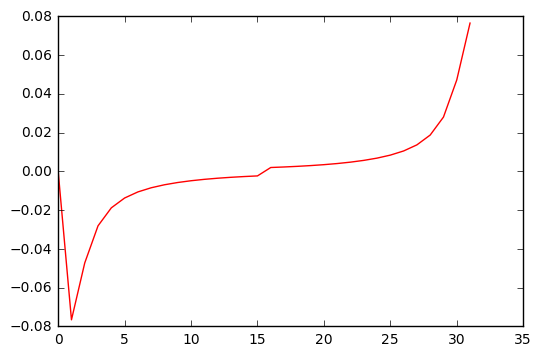

1.0953101798


In [48]:
def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

# print(integrand_minus(upsilon_space))
plt.plot(integrand_minus(upsilon_space).real, color = 'g')
plt.show()

plt.plot(integrand_minus(upsilon_space).imag, color = 'r')
plt.show()

print(q)

Теперь реализуем кусок в виде fft:
$$F^-(x) = 1_{[0,+\infty)}(x)e^{-x\omega_+}\color{red}{\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} intfunc(\upsilon) d(\upsilon)} $$

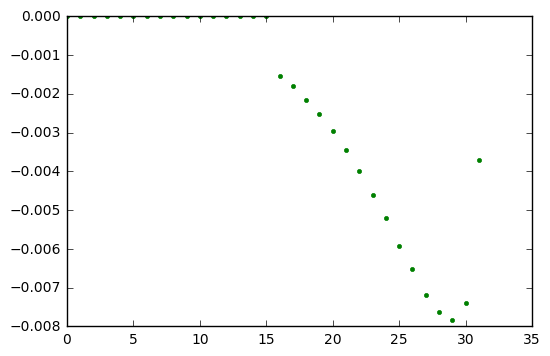

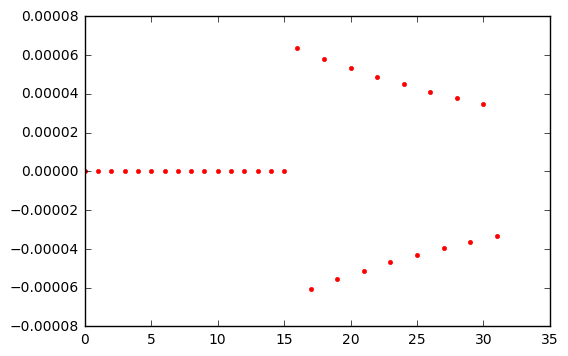

In [49]:
# factor functions
def F_minus_capital(x_array):
    big_integral = fft.ifft(integrand_minus(upsilon_space))
    osc_exponent = [exp(-1*x_elem*omega_plus) for x_elem in x_array]
    weighted_big_integral = np.array(osc_exponent) * np.array(big_integral)
    indicator_array = np.where(np.array(x_array) >= 0, 1,0)
    return indicator_array * weighted_big_integral

# print(y_space)
# print(F_minus_capital(y_space))

plt.plot(F_minus_capital(y_space).real, 'g.')
plt.show()

plt.plot(F_minus_capital(y_space).imag, 'r.')
plt.show()

Теперь нас интересует $$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

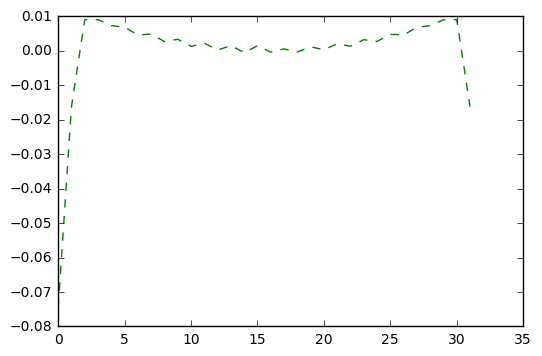

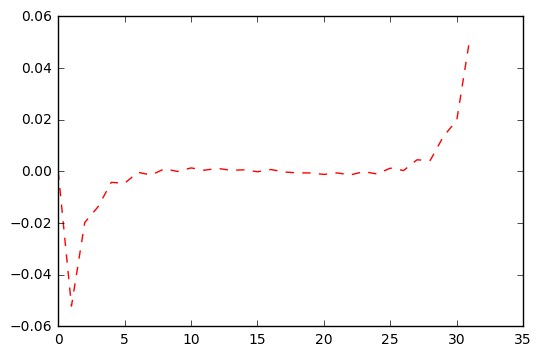

In [50]:
def F_minus_capital_hat(xi_array):
    return fft.fft(F_minus_capital(y_space))

plt.plot(F_minus_capital_hat(y_space).real, 'g--')
plt.show()

plt.plot(F_minus_capital_hat(y_space).imag, 'r--')
plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^-_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^-(0)$

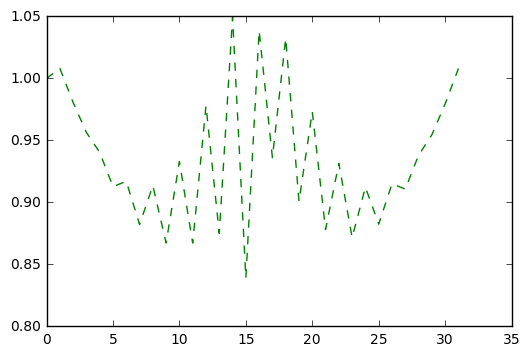

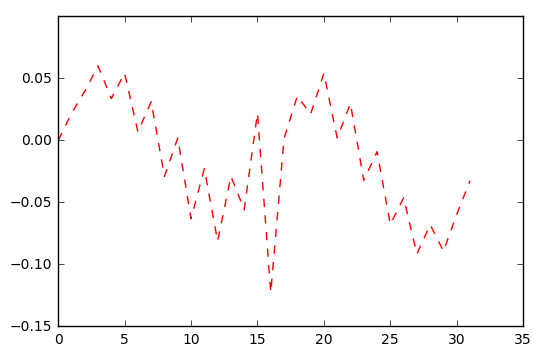

In [51]:

def make_phi_minus_array(xi_array):
    first_term = -1j * F_minus_capital(np.zeros(len(y_space))) * np.array(xi_array)
    second_term = - np.array(xi_array) * np.array(xi_array) * F_minus_capital_hat(xi_array)
    return exp(first_term + second_term)

plt.plot(make_phi_minus_array(xi_space).real, 'g--')
plt.show()

plt.plot(make_phi_minus_array(xi_space).imag, 'r--')
plt.show()

## Фи-плюс

$\phi^+_q(\xi)$ будут иметь вид:

$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)], $$
$$ F^+(x) = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty + i\omega_-}^{+\infty + i\omega_-} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta = $$
$$ = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_-)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon) = $$ 
$$ = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon);$$
$$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx. $$

In [52]:
# преобразование Фурье должно допускать вычисление интеграла c \xi
# но поскольку мы имеем дело с ПДО, нужно ещё знать, с какими именно
xi_space = fft.fftfreq(M, d=d)
upsilon_space = fft.fftfreq(M, d=d)

omega_minus = -1

# Теперь надо поколдовать с функцией F(x). Кодировать её для каждого отдельного значения x можно, 
# но для этого придётся использовать медленные методы вычисления интегралов.
# Поэтому она должна принимать  массив длиной M и обрабатывать его.

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2}, \upsilon \in \upsilon\_space$$

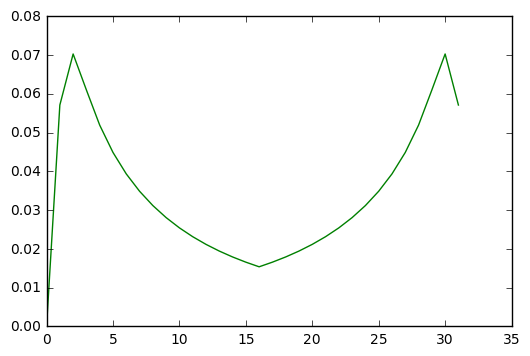

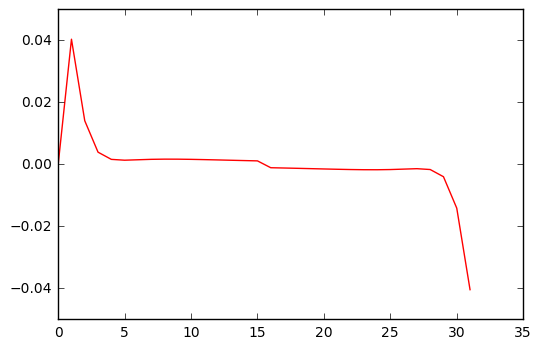

In [53]:
def integrand_plus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_minus)) / (upsilon + 1j*omega_minus)**2 for upsilon in upsilon_array])

# print(integrand_minus(upsilon_space))
plt.plot(integrand_plus(upsilon_space).real, color = 'g')
plt.show()

plt.plot(integrand_plus(upsilon_space).imag, color = 'r')
plt.show()

Теперь реализуем кусок в виде fft:
$$1_{(-\infty, 0]}(x)e^{-x\omega_-}\color{red}{\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} intfunc(\upsilon) d(\upsilon)} $$

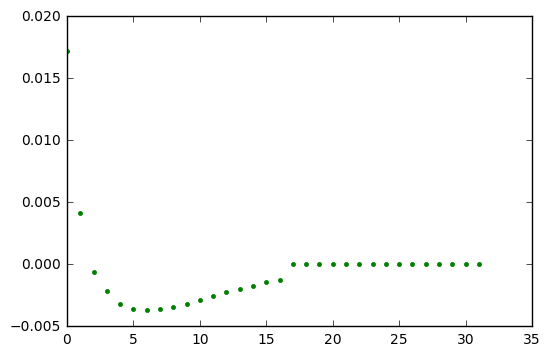

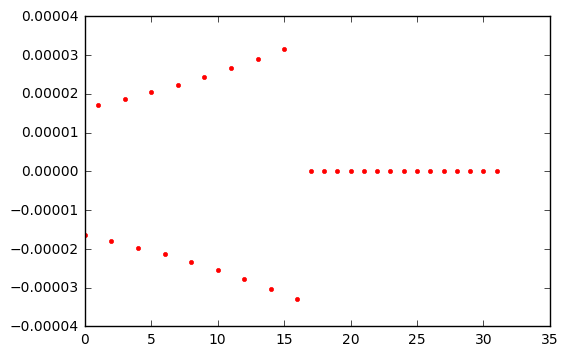

In [54]:
# factor functions
def F_plus_capital(x_array):
    big_integral = fft.ifft(integrand_plus(upsilon_space))
    osc_exponent = [exp(-1 * x_elem * omega_minus) for x_elem in x_array] 
    weighted_big_integral = np.array(osc_exponent) * np.array(big_integral)
    indicator_array = np.where(np.array(x_array) <= 0, 1,0)
    return indicator_array * weighted_big_integral
# print(F_capital(y_space))

# print(F_plus_capital(y_space))
plt.plot(F_plus_capital(y_space).real, 'g.')
plt.show()

plt.plot(F_plus_capital(y_space).imag, 'r.')
plt.show()

Теперь нас интересует $$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx $$

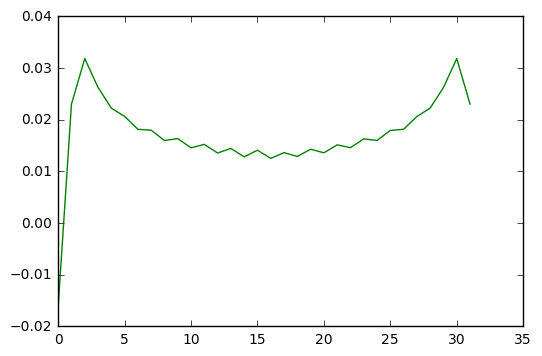

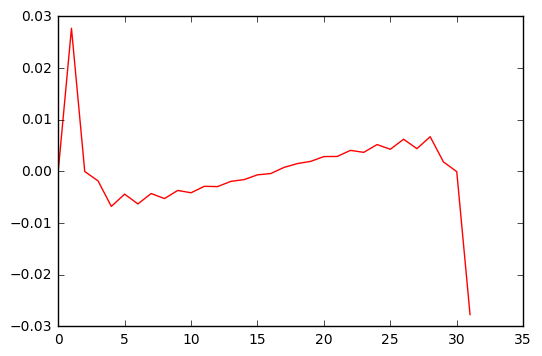

In [55]:
def F_plus_capital_hat(xi_array):
    return fft.fft(F_plus_capital(y_space))

plt.plot(F_plus_capital_hat(xi_space).real, 'g')
plt.show()

plt.plot(F_plus_capital_hat(xi_space).imag, 'r')
plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^+_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^+(0)$


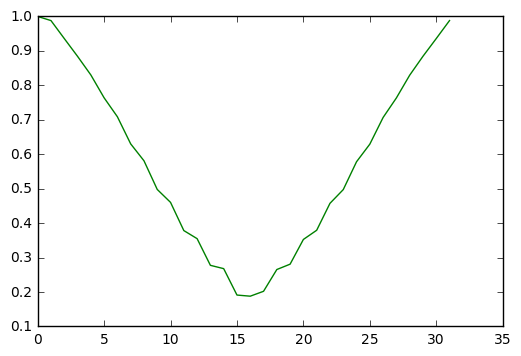

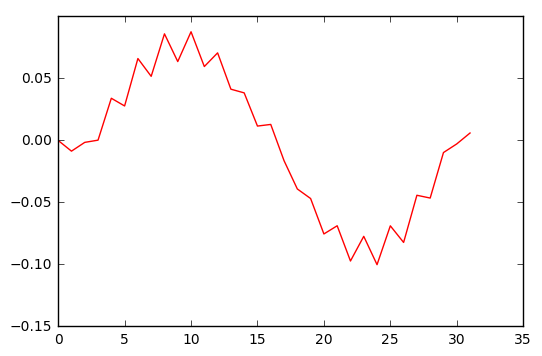

In [56]:
def make_phi_plus_array(xi_array):
    first_term = 1j * F_plus_capital(np.zeros(len(y_space))) * np.array(xi_array)
    second_term = - np.array(xi_array) * np.array(xi_array) * F_plus_capital_hat(xi_array)
    return exp(first_term + second_term)

# make_phi_plus_array(xi_space)

plt.plot(make_phi_plus_array(xi_space).real, 'g')
plt.show()

plt.plot(make_phi_plus_array(xi_space).imag, 'r')
plt.show()

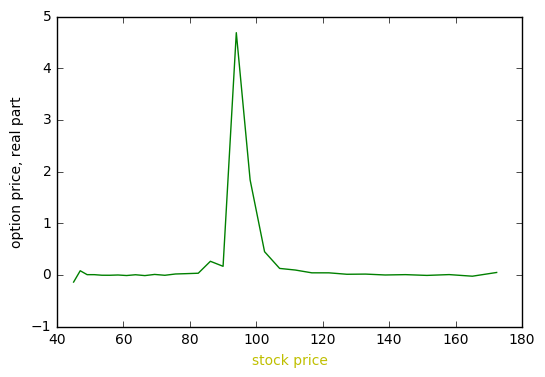

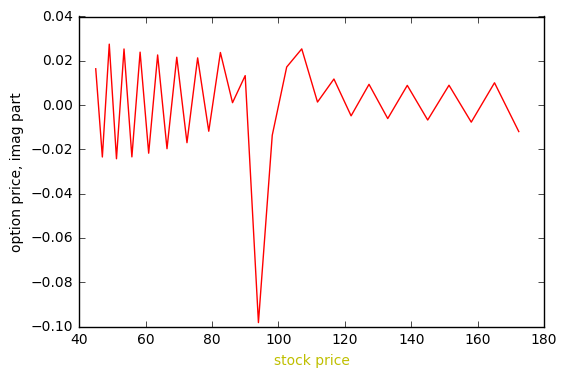

In [57]:
phi_minus_array = make_phi_minus_array(xi_space)
phi_plus_array = make_phi_plus_array(xi_space)

# main cycle (iterating over time)
f_n = array(f_N)
#plt.plot(original_prices_array, f_n)
for i in range(N):
   f_n_plus_1 = factor * fft.ifft(phi_minus_array *
       fft.fft(indicator(fft.ifft(phi_plus_array * fft.fft(f_n)), H)))
   f_n = f_n_plus_1

plt.plot(original_prices_array, f_n_plus_1.real, 'g')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, real part')
plt.show()

plt.plot(original_prices_array, f_n_plus_1.imag, 'r')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, imag part')
plt.show()